In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt,rc
from matplotlib.animation import FuncAnimation as animate
rc('animation' ,html='html5')
%matplotlib inline

In [ ]:
class Dataset(object):
    def __init__(self) -> None:
        # source : https://cs231n.github.io/neural-networks-case-study/
        N = 100 # number of points per class
        D = 2 # dimensionality
        K = 3 # number of classes
        self.x = np.zeros((N*K,D)) # data matrix (each row = single example)
        self.y = np.zeros(N*K, dtype='uint8') # class labels
        for j in range(K):
            ix = range(N*j,N*(j+1))
            r = np.linspace(0.0,1,N) # radius
            t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
            self.x[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
            self.y[ix] = j

    @property
    def plot(self):
        plt.scatter(self.x[:,0],self.x[:,1],c=self.y,s=40,cmap=plt.cm.coolwarm)
        plt.show()

    def __getitem__(self,index):
        return self.x[index],self.y[index]

    def __len__(self):
        return len(self.x)

In [ ]:
data = Dataset()
data.plot

In [ ]:
class NeuralNet:
  def __init__(self, inFeatures, hiddenFeatures, numClasses) -> None:
    self.__hiddenFeatures = hiddenFeatures
    self.__numclass = numClasses
    self.w1 = np.random.rand(inFeatures, hiddenFeatures)
    self.w2 = np.random.rand(hiddenFeatures, numClasses)

  def forward(self, x):
    self.__z = np.matmul(self.w1.T, x)
    self.__a = self.__sigmoid(self.__z)
    self.__s = np.matmul(self.w2.T, self.__a)
    self.__probs = self.__softmax(self.__s)
    return self.__s, self.__probs

  def __softmax(self, x):
        a = np.exp(x)
        return a/a.sum()

  def __sigmoid(self, x):
      return 1/(1+np.exp(-x))

  # dw1 <- dw2 <- cost(y')
  def backward(self, x, y):
    self.__probs[y] -= 1
    diag2 = np.diag(self.__probs.ravel())
    dw2 = np.matmul(self.__a, np.ones((1, self.__numclass)))
    dw2 = np.matmul(dw2, diag2)

    a = self.__sigmoid(self.__z)
    d = np.matmul(self.w2, self.__probs) * (a * (1 - a))
    diag1 = np.diag(d.ravel())
    dw1 = np.matmul(x, np.ones((1, self.__hiddenFeatures)))
    dw1 = np.matmul(dw1, diag1)
    return dw1, dw2

In [ ]:
from tqdm import tqdm

np.random.seed(0)
h = .02
x_min, x_max = data.x[:, 0].min() - 0.1, data.x[:, 0].max() + 0.1
y_min, y_max = data.x[:, 1].min() - 0.1, data.x[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

fig,ax = plt.subplots(figsize=(10,7))


model = NeuralNet(inFeatures=2,hiddenFeatures=10,numClasses=3)

LEARNING_RATE = 0.1
LOSS = []

# Training loop
for epoch in range(500):
    loss = 0
    for x, y in data:
        x = x.reshape((len(x), 1))
        scores, p = model.forward(x)
        loss += -np.log(p[y])

        dw1, dw2 = model.backward(x, y)
        model.w1 -= LEARNING_RATE * dw1
        model.w2 -= LEARNING_RATE * dw2

    LOSS.append(loss / len(data))

# After training, plot the decision boundary
z, _ = model.forward(np.c_[xx.ravel(), yy.ravel()].T)
z = np.argmax(z, axis=0)
z = z.reshape(xx.shape)

# Plot the decision boundary
ax.contourf(xx, yy, z, alpha=0.7, cmap=plt.cm.coolwarm)

# Scatter plot for the data points
scatter = ax.scatter(data.x[:, 0], data.x[:, 1], c=data.y, cmap=plt.cm.coolwarm)

plt.xlim([-1, 1])
plt.ylim([-1, 1])

# Add a legend
legend_labels = [f"Class {i}" for i in range(3)]
ax.legend(legend_labels, loc='upper right')

# Show the plot
plt.show()

#CS231n Convolutional Neural Networks for Visual Recognition

Lets generate a classification dataset that is not easily linearly separable. Our favorite example is the spiral dataset, which can be generated as follows:

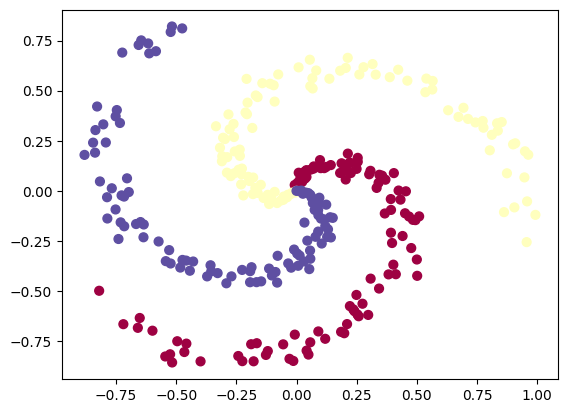

In [6]:
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

#Train a Linear Classifier

In [ ]:
# initialize parameters randomly
W = 0.01 * np.random.randn(D,K)
b = np.zeros((1,K))

In [16]:
# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

In [36]:
# gradient descent loop
num_examples = X.shape[0]
for i in range(200):

  # evaluate class scores, [N x K]
  scores = np.dot(X, W) + b

  # compute the class probabilities
  exp_scores = np.exp(scores)
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

  # compute the loss: average cross-entropy loss and regularization
  correct_logprobs = -np.log(probs[range(num_examples),y])
  data_loss = np.sum(correct_logprobs)/num_examples
  reg_loss = 0.5*reg*np.sum(W*W)
  loss = data_loss + reg_loss
  if i % 10 == 0:
    print ("iteration %d: loss %f" % (i, loss))

  # compute the gradient on scores
  dscores = probs
  dscores[range(num_examples),y] -= 1
  dscores /= num_examples

  # backpropate the gradient to the parameters (W,b)
  dW = np.dot(X.T, dscores)
  db = np.sum(dscores, axis=0, keepdims=True)

  dW += reg*W # regularization gradient

  # perform a parameter update
  W += -step_size * dW
  b += -step_size * db

iteration 0: loss 0.750462
iteration 10: loss 0.750419
iteration 20: loss 0.750387
iteration 30: loss 0.750362
iteration 40: loss 0.750344
iteration 50: loss 0.750330
iteration 60: loss 0.750320
iteration 70: loss 0.750312
iteration 80: loss 0.750306
iteration 90: loss 0.750301
iteration 100: loss 0.750298
iteration 110: loss 0.750295
iteration 120: loss 0.750293
iteration 130: loss 0.750292
iteration 140: loss 0.750290
iteration 150: loss 0.750290
iteration 160: loss 0.750289
iteration 170: loss 0.750288
iteration 180: loss 0.750288
iteration 190: loss 0.750288


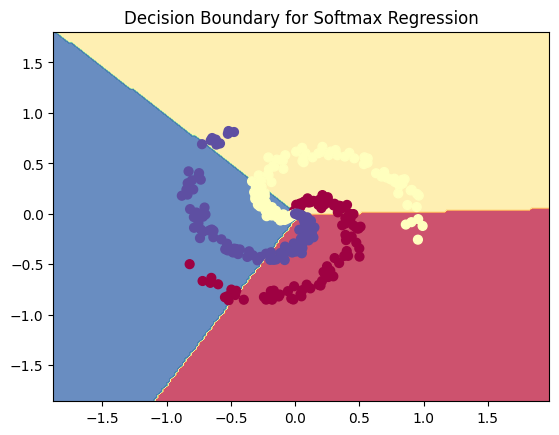

In [37]:
# Function to plot decision boundary
def plot_decision_boundary(X, y, W, b):
    h = 0.02  # Step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)

# Visualize decision boundary
plot_decision_boundary(X, y, W, b)
plt.title("Decision Boundary for Softmax Regression")
plt.show()


In [38]:
# evaluate training set accuracy
scores = np.dot(X, W) + b
predicted_class = np.argmax(scores, axis=1)
print ('training accuracy: %.2f' % (np.mean(predicted_class == y)))

training accuracy: 0.50


In [39]:
# initialize parameters randomly
h = 100 # size of hidden layer
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))

# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

# gradient descent loop
num_examples = X.shape[0]
for i in range(10000):

  # evaluate class scores, [N x K]
  hidden_layer = np.maximum(0, np.dot(X, W) + b) # note, ReLU activation
  scores = np.dot(hidden_layer, W2) + b2

  # compute the class probabilities
  exp_scores = np.exp(scores)
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

  # compute the loss: average cross-entropy loss and regularization
  correct_logprobs = -np.log(probs[range(num_examples),y])
  data_loss = np.sum(correct_logprobs)/num_examples
  reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2)
  loss = data_loss + reg_loss
  if i % 1000 == 0:
    print ("iteration %d: loss %f" % (i, loss))

  # compute the gradient on scores
  dscores = probs
  dscores[range(num_examples),y] -= 1
  dscores /= num_examples

  # backpropate the gradient to the parameters
  # first backprop into parameters W2 and b2
  dW2 = np.dot(hidden_layer.T, dscores)
  db2 = np.sum(dscores, axis=0, keepdims=True)
  # next backprop into hidden layer
  dhidden = np.dot(dscores, W2.T)
  # backprop the ReLU non-linearity
  dhidden[hidden_layer <= 0] = 0
  # finally into W,b
  dW = np.dot(X.T, dhidden)
  db = np.sum(dhidden, axis=0, keepdims=True)

  # add regularization gradient contribution
  dW2 += reg * W2
  dW += reg * W

  # perform a parameter update
  W += -step_size * dW
  b += -step_size * db
  W2 += -step_size * dW2
  b2 += -step_size * db2

iteration 0: loss 1.098619
iteration 1000: loss 0.279160
iteration 2000: loss 0.250836
iteration 3000: loss 0.245926
iteration 4000: loss 0.243823
iteration 5000: loss 0.243043
iteration 6000: loss 0.242991
iteration 7000: loss 0.242264
iteration 8000: loss 0.242401
iteration 9000: loss 0.241792


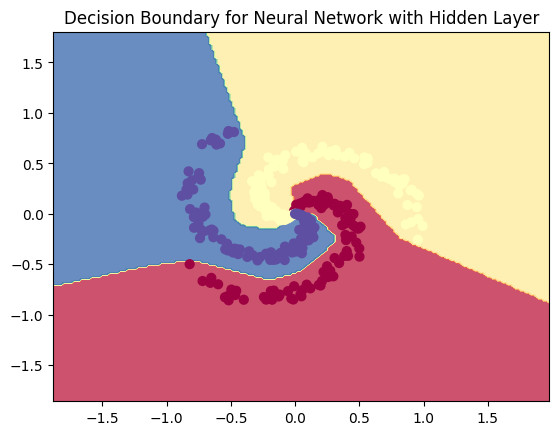

In [42]:
def plot_decision_boundary(X, y, W, b, W2, b2):
    h = 0.02  # Step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Forward pass through the network to get hidden layer activations
    hidden_layer = np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b)

    # Forward pass through the second layer to get scores
    scores = np.dot(hidden_layer, W2) + b2

    # Determine the predicted class labels
    Z = np.argmax(scores, axis=1)
    Z = Z.reshape(xx.shape)

    # Plot decision boundary and data points
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)

# Visualize decision boundary
plot_decision_boundary(X, y, W, b, W2, b2)
plt.title("Decision Boundary for Neural Network with Hidden Layer")
plt.show()


In [40]:
# evaluate training set accuracy
hidden_layer = np.maximum(0, np.dot(X, W) + b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
print ('training accuracy: %.2f' % (np.mean(predicted_class == y)))

training accuracy: 0.98
